In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mushroom-classification/mushrooms.csv


In [3]:
dataset = pd.read_csv("/kaggle/input/mushroom-classification/mushrooms.csv")
dataset.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [5]:
y = dataset['class']
x = dataset.drop(columns=['class'])
x.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
np.bincount(y)

array([4208, 3916])

In [23]:
for cat_col in x.columns:
    x[cat_col] = x[cat_col].astype('category').cat.codes

In [24]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", x_train.shape)
print("Validation set shape:", x_val.shape)
print("Testing set shape:", x_test.shape)

Training set shape: (6499, 22)
Validation set shape: (812, 22)
Testing set shape: (813, 22)


## First lightgbm model
Mostly to check which parameters we want to use for training

In [26]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

categorical_features = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat']

train_data = lgb.Dataset(x_train, label=y_train, categorical_feature=categorical_features)
val_data = lgb.Dataset(x_val, label=y_val, categorical_feature=categorical_features)
test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'is_unbalance': 'true',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}

lgb_model = lgb.train(params, train_data, valid_sets=[train_data, val_data], num_boost_round=10)

[LightGBM] [Info] Number of positive: 3134, number of negative: 3365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 6499, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482228 -> initscore=-0.071118
[LightGBM] [Info] Start training from score -0.071118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

Accuracy: 99.75%
Precision: 99.76%
Recall: 99.75%
F1: 99.75%


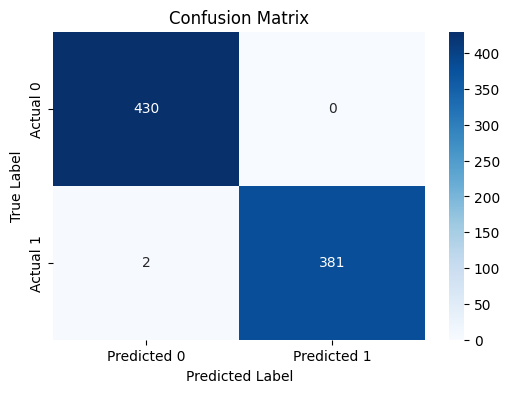

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration)
y_pred_class = [1 if prob >= 0.5 else 0 for prob in y_pred]

accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, average='weighted')
recall = recall_score(y_test, y_pred_class, average='weighted')
f1 = f1_score(y_test, y_pred_class, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_class)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

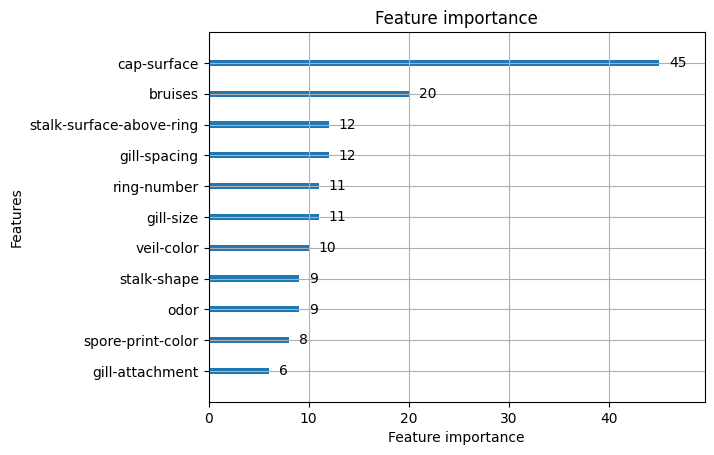

In [28]:
lgb.plot_importance(lgb_model, importance_type='split')
plt.show()

## Training with optuna

In [62]:
import optuna
from sklearn.model_selection import StratifiedKFold

def objective(trial):

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int("num_leaves", 20, 150),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 20, 100),
        'feature_fraction': trial.suggest_float("feature_fraction", 0.5, 0.9),
        'bagging_fraction': trial.suggest_float("bagging_fraction", 0.5, 0.9),
        'bagging_freq': trial.suggest_int("bagging_freq", 1, 10),
        'lambda_l1': trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        'verbose': -1
    }

    categorical_features = ['cap-surface', 'bruises', 'odor','gill-attachment', 
                            'gill-spacing', 'gill-size','stalk-surface-above-ring', 
                            'veil-color', 'ring-number', 'spore-print-color']

    train_data = lgb.Dataset(x_train, label=y_train, categorical_feature=categorical_features)
    val_data = lgb.Dataset(x_val, label=y_val, categorical_feature=categorical_features)
    test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, val_data], num_boost_round=10)

    y_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration)
    y_pred_class = [1 if prob >= 0.5 else 0 for prob in y_pred]

    accuracy = accuracy_score(y_test, y_pred_class)

    return accuracy

In [32]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

trial = study.best_trial

print("Accuracy: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2024-11-05 17:53:29,701] A new study created in memory with name: no-name-fa5929fe-2dd5-4275-8e65-2bc3e818fb9a
[I 2024-11-05 17:53:29,827] Trial 0 finished with value: 0.996309963099631 and parameters: {'learning_rate': 0.12477587240854363, 'num_leaves': 33, 'min_data_in_leaf': 38, 'feature_fraction': 0.5230690329979407, 'bagging_fraction': 0.586007498041919, 'bagging_freq': 1, 'lambda_l1': 1.1592886073918441e-05, 'lambda_l2': 2.0064082013954153e-06}. Best is trial 0 with value: 0.996309963099631.
[I 2024-11-05 17:53:29,876] Trial 1 finished with value: 0.985239852398524 and parameters: {'learning_rate': 0.025540855313892163, 'num_leaves': 35, 'min_data_in_leaf': 89, 'feature_fraction': 0.8000829001603356, 'bagging_fraction': 0.7917409970692506, 'bagging_freq': 8, 'lambda_l1': 1.0897875639338395, 'lambda_l2': 0.001793375632689354}. Best is trial 0 with value: 0.996309963099631.
[I 2024-11-05 17:53:29,945] Trial 2 finished with value: 0.992619926199262 and parameters: {'learning_rate

Accuracy: 1.0
Best hyperparameters: {'learning_rate': 0.28608157120321165, 'num_leaves': 111, 'min_data_in_leaf': 64, 'feature_fraction': 0.5903008649641103, 'bagging_fraction': 0.8929075103461539, 'bagging_freq': 3, 'lambda_l1': 0.015155888367147308, 'lambda_l2': 1.0292429137309793e-08}


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] feature_fraction is set=0.5903008649641103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5903008649641103
[LightGBM] [Warning] lambda_l2 is set=1.0292429137309793e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0292429137309793e-08
[LightGBM] [Warning] lambda_l1 is set=0.015155888367147308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015155888367147308
[LightGBM] [Warning] bagging_fraction is set=0.8929075103461539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8929075103461539
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] feature_fraction is set=0.5903008649641103, col

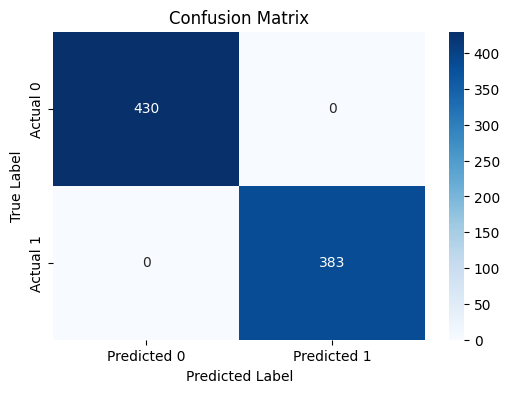

In [34]:
best_params = study.best_trial.params
lgb_model_best = lgb.LGBMClassifier(**best_params)

lgb_model_best.fit(x_train, y_train)

y_pred = lgb_model_best.predict(x_test)
y_pred_class = [1 if prob >= 0.5 else 0 for prob in y_pred]
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, average='weighted')
recall = recall_score(y_test, y_pred_class, average='weighted')
f1 = f1_score(y_test, y_pred_class, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_class)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [35]:
optuna.visualization.plot_optimization_history(study)

In [36]:
optuna.visualization.plot_param_importances(study)

## Training with CMA-ES

In [54]:
%pip install cmaes

Note: you may need to restart the kernel to use updated packages.


In [65]:
import cma

categorical_features = ['cap-surface', 'bruises', 'odor', 'gill-attachment', 
                        'gill-spacing', 'gill-size', 'stalk-surface-above-ring', 
                        'veil-color', 'ring-number', 'spore-print-color']

def objective(params):
    learning_rate, num_leaves, min_data_in_leaf, feature_fraction, bagging_fraction, bagging_freq, lambda_l1, lambda_l2 = params

    lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'learning_rate': learning_rate,
        'num_leaves': int(num_leaves),
        'min_data_in_leaf': int(min_data_in_leaf),
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': int(bagging_freq),
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'verbose': -1
    }

    train_data = lgb.Dataset(x_train, label=y_train, categorical_feature=categorical_features)
    val_data = lgb.Dataset(x_val, label=y_val, categorical_feature=categorical_features)
    test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

    lgb_model = lgb.train(lgb_params, train_data, valid_sets=[train_data, val_data], num_boost_round=10)

    y_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration)
    y_pred_class = [1 if prob >= 0.5 else 0 for prob in y_pred]

    accuracy = accuracy_score(y_test, y_pred_class)

    return -accuracy

lower_bounds = [0.01, 20, 20, 0.5, 0.5, 1, 1e-8, 1e-8]
upper_bounds = [0.3, 150, 100, 0.9, 0.9, 10, 10.0, 10.0]
bounds = [lower_bounds, upper_bounds]

initial_params = [0.1, 31, 20, 0.8, 0.8, 5, 1e-5, 1e-5]

result = cma.fmin(objective, initial_params, 0.5, {'bounds': bounds})

print("Best parameters found by CMA-ES:")
print(result[0])
print("Objective function value (negative accuracy):", result[1])


/opt/conda/lib/python3.10/site-packages/cma/evolution_strategy.py:1244: UserWarning:

Sampling standard deviation i=0 at iteration 0 change by 0.1933333333333333 to stds[0]=0.09666666666666665

/opt/conda/lib/python3.10/site-packages/cma/evolution_strategy.py:1244: UserWarning:

Sampling standard deviation i=3 at iteration 0 change by 0.2666616667135414 to stds[3]=0.13333333333333333

/opt/conda/lib/python3.10/site-packages/cma/evolution_strategy.py:1244: UserWarning:

Sampling standard deviation i=4 at iteration 0 change by 0.2666600000833326 to stds[4]=0.13333333333333333



(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=912612, Tue Nov  5 18:30:09 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -1.000000000000000e+00 1.0e+00 4.64e-01  9e-02  5e-01 0:00.9
    2     20 -9.987699876998770e-01 1.2e+00 4.55e-01  9e-02  5e-01 0:01.7
    3     30 -9.987699876998770e-01 1.3e+00 4.40e-01  9e-02  5e-01 0:02.3
termination on tolflatfitness=1 (Tue Nov  5 18:30:11 2024)
final/bestever f-value = -9.987700e-01 -1.000000e+00 after 31/3 evaluations
incumbent solution: [0.0604442279214767, 30.33909404645157, 20.007005743366904, 0.8935261275903761, 0.67555267414972, 5.427713004633996, 0.00033718142518774236, 0.1564037020803451]
std deviation: [0.08552802310807478, 0.43605828043984457, 0.4635653232837436, 0.11859765489104278, 0.11409380539214962, 0.41407500606566305, 0.42138551804503277, 0.43246691191626446]
Best parameters found by CMA-ES:
[2.45871354e-01 3.02167005e+01 2.01075508e+01 6.52163025e-01
 8.78081877e-01 5.0999

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1: 100.00%


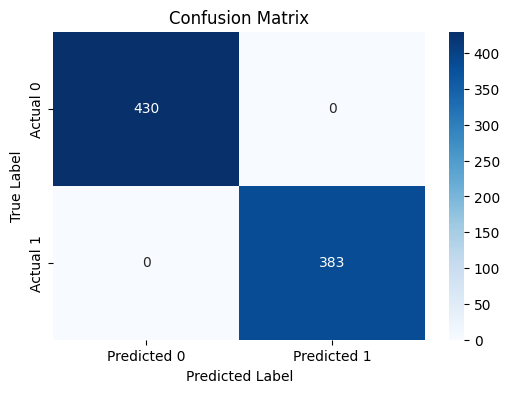

In [66]:
best_params = result[0]
lgb_model_best = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    learning_rate=best_params[0],
    num_leaves=int(best_params[1]),
    min_data_in_leaf=int(best_params[2]),
    feature_fraction=best_params[3],
    bagging_fraction=best_params[4],
    bagging_freq=int(best_params[5]),
    lambda_l1=best_params[6],
    lambda_l2=best_params[7],
    verbose=-1
)

lgb_model_best.fit(x_train, y_train)

y_pred = lgb_model_best.predict(x_test)
y_pred_class = [1 if prob >= 0.5 else 0 for prob in y_pred]
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, average='weighted')
recall = recall_score(y_test, y_pred_class, average='weighted')
f1 = f1_score(y_test, y_pred_class, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_class)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()